# Proglearn: Scene Segmentation (Neural Network)

Neuro Data Design I: Fall 2021

This tutorial provides a walkthrough for applying a neural network (Unet architecture) for scene segmentation. Following this, an attempt was made to apply this same architecture to the Proglearn framework.

In [1]:
!pip install seaborn

In [3]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from functions.scene_segmentation_nn_tutorial_functions import * # cv2 required
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input
from tensorflow.keras.utils import Sequence
import pickle as pkl

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

## Preprocessing

Images from the ADE20K consistency set are used in this exercise, which contains 64 images where different objects in the scene are segmented into different colors. However, between different images, the same objects do not necessarily share the same color. As a result, the preprocessing step not only involves separating the data into train and test sets but also relabeling pixel values from color values to class values.

In [49]:
# data directory
DATASET_PATH="ADE20K_2021_17_01"
index_file = "index_ade20k.pkl"
with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
    index_ade20k = pkl.load(f)

test = [i for i in index_ade20k['folder'] if "industrial in i"]
# get image file names
training_files = ["{}/{}".format(i, j) for i,j in zip(index_ade20k['folder'], index_ade20k['filename']) if "training/nature_landscape" in i]
validation_files = ["{}/{}".format(i, j) for i,j in zip(index_ade20k['folder'], index_ade20k['filename']) if "validation/nature_landscape" in i]
validation_files, testing_files, _, _ = train_test_split(validation_files, np.zeros(len(validation_files)), test_size=0.5)

masks = [i.replace('.jpg', '_seg.png') for i in training_files]
a=np.array([])
for i in masks:
    img = get_mask(img_to_array(load_img(i, target_size=(128,128))))
    a = np.append(a, np.unique(img))
classes = np.unique(a)
n_classes = len(classes)

def label_remapper(img):
    img2 = np.zeros_like(img)
    for i, label in enumerate(classes):
        img2[img == label] = i
    return img2

In [50]:
print("Classes: {}".format(n_classes))
print("Train Size: {}".format(len(training_files)))
print("Test Size: {}".format(len(testing_files)))
print("Validation Size: {}".format(len(validation_files)))

Classes: 527
Train Size: 3333
Test Size: 78
Validation Size: 77


Preprocessing function for obtaining image mask.

In [51]:
class DataLoader(Sequence):
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_mask_img_paths = [i.replace('.jpg', '_seg.png') for i in self.input_img_paths[i : i + self.batch_size]]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_mask_img_paths):
            img = get_mask(img_to_array(load_img(path, target_size=self.img_size)))
            y[j] = label_remapper(np.expand_dims(img, 2))
        return x, y

The images are loaded and preprocessed

Hyper parameters for training:

- `n_epoch`: number of training epochs
- `n_batch_items`: number of training points per epoch
- `n_test`: number of testing points
- `n_val`: number of validation points
- `learn_rate`: learning rate

In [52]:
# hyperparameters
n_epoch = 25
n_batch_items = 16
learn_rate = 0.01

In [58]:
# create data loaders
training_data = DataLoader(n_batch_items, (128, 128), training_files)
validation_data = DataLoader(n_batch_items, (128, 128), validation_files)
testing_data = DataLoader(len(testing_files), (128, 128), testing_files)

x, y = training_data[0]

Create neural network (Unet)

In [59]:
# create Unet model
input_layer = Input(shape = x[0].shape)
model = unet(input_layer, n_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_38[0][0]']              
                                )                                                           

## Neural Network

A Unet neural network is constructed, which is a type of neural network used in image segmentation commonly used in biomedical applications. This network uses the Adam optimizer and computes loss via Sparse Categorical Crossentropy. An aditional metric called the Dice score iis also computed, which calculates the similarity between the predicted segmentation and the ground truth segmentation.

In [60]:
# compile model with Adam optimizer, Spare Categorical Cross entropy loss, and include dice coefficient calculation
model.compile(optimizer=Adam(learning_rate=learn_rate),
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', dice])

### Training

The Unet model is trained according to the hyperparameters previously specified.

In [61]:
# compile model with Adam optimizer, Spare Categorical Cross entropy loss, and include dice coefficient calculation
model_history = model.fit(
                        training_data,
                        validation_data=validation_data,
                        epochs=n_epoch, 
                        verbose=1)

Epoch 1/25
208/208 [==============================] - 944s 5s/step - loss: 322724416.0000 - accuracy: 6.7340e-04 - dice: 2.9318e-04 - val_loss: 2.9053 - val_accuracy: 0.0000e+00 - val_dice: 0.0000e+00
Epoch 2/25
208/208 [==============================] - 681s 3s/step - loss: 2.8665 - accuracy: 0.0000e+00 - dice: 3.1720e-07 - val_loss: 2.7962 - val_accuracy: 0.0000e+00 - val_dice: 0.0000e+00
Epoch 3/25
208/208 [==============================] - 535s 3s/step - loss: 2.7819 - accuracy: 1.4470e-04 - dice: 7.6416e-10 - val_loss: 2.7807 - val_accuracy: 1.9073e-06 - val_dice: 0.0000e+00
Epoch 4/25
208/208 [==============================] - 480s 2s/step - loss: 2.7645 - accuracy: 8.4099e-04 - dice: 1.4880e-07 - val_loss: 2.6655 - val_accuracy: 4.1866e-04 - val_dice: 0.0000e+00
Epoch 5/25
208/208 [==============================] - 428s

In [76]:
print("Final Training Loss: {}".format(model_history.history['loss'][-1]))
print("Final Validation Loss: {}".format(model_history.history['val_loss'][-1]))
print("Final Training Accuracy: {}".format(model_history.history['accuracy'][-1]))
print("Final Validation Accuracy: {}".format(model_history.history['val_accuracy'][-1]))
print("Final Training Dice: {}".format(model_history.history['dice'][-1]))
print("Final Validation Dice: {}".format(model_history.history['val_dice'][-1]))
model.save('model')

Final Training Loss: 2.629979133605957
Final Validation Loss: 2.6031153202056885
Final Training Accuracy: 0.01485118456184864
Final Validation Accuracy: 0.0137481689453125
Final Training Dice: 3.9583602529091877e-07
Final Validation Dice: 0.0
INFO:tensorflow:Assets written to: model/assets


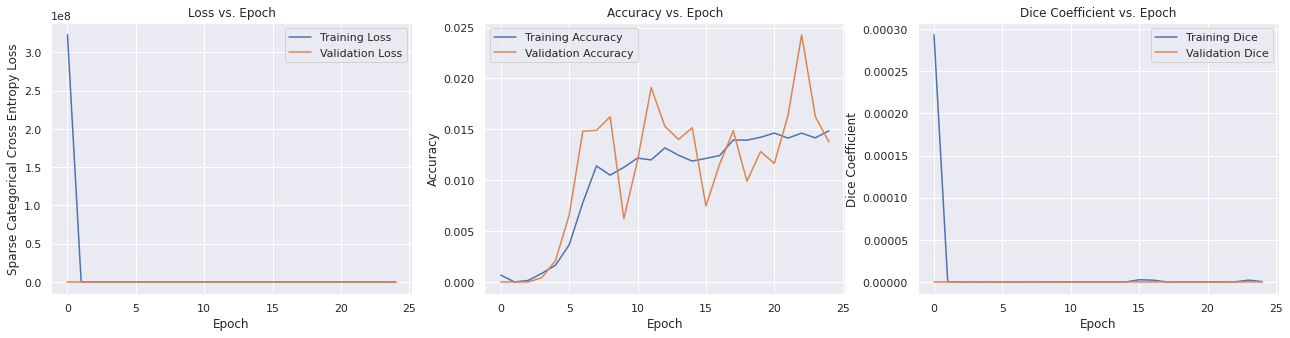

In [62]:
%matplotlib inline
def evaluate(model, X_test, plot_frequency=1):
    X, Y = X_test
    dices = np.zeros(X.shape[0])
    accuracy = np.zeros(X.shape[0])
    mut_info = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        m = tf.keras.metrics.Accuracy()
        pred = model.predict(tf.convert_to_tensor([X[i]]))
        score = dice(Y[i], pred)
        if i % plot_frequency == 0:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(tf.cast(X[i], tf.int32))
            plt.title("Image")
            plt.subplot(1,3,2)
            plt.imshow(Y[i].reshape(128,128), cmap = "Set1")
            plt.title("Ground Truth Segmentation Mask")
            plt.subplot(1,3,3)
            plt.imshow(np.argmax(pred, axis=3).reshape(128,128), cmap= "Set1")
            plt.title("Predicted Mask (Dice: {:.4f})".format(score.numpy()))
            dices[i] = score.numpy()
            m.update_state(Y[i].flatten(), np.argmax(pred, axis=3).flatten())
        accuracy[i] = m.result().numpy()
    print("Mean Test Dice: {:.4f}".format(np.mean(dices)))
    print("Mean Test Accuracy: {:.4f}".format(np.mean(accuracy)))

def plot_metrics(history):
    epochs = history.epoch
    plt.figure(figsize=(22,5))

    plt.subplot(1,3,1)
    plt.plot(epochs, history.history['loss'], label="Training Loss")
    plt.plot(epochs, history.history['val_loss'], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Sparse Categorical Cross Entropy Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, history.history['accuracy'], label="Training Accuracy")
    plt.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epoch")
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(epochs, history.history['dice'], label="Training Dice")
    plt.plot(epochs, history.history['val_dice'], label="Validation Dice")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Dice Coefficient")
    plt.title("Dice Coefficient vs. Epoch")

plot_metrics(model_history)

### Testing

With the model now trained, predictions are made with the model to evaluate its accuracy.

Evaluation on held-out testing data:

Mean Test Dice: 0.0034
Mean Test Accuracy: 0.0439


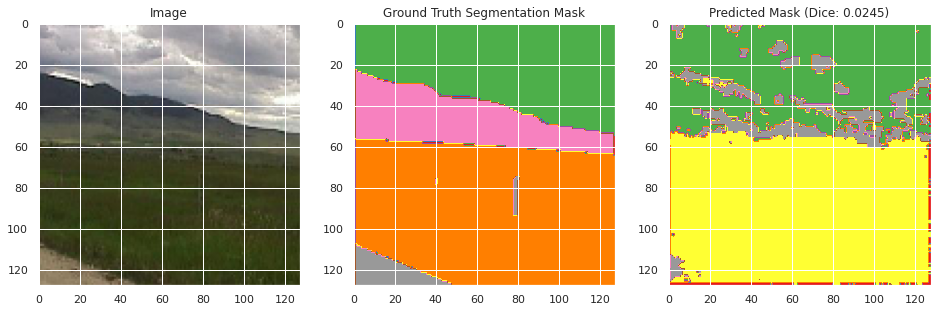

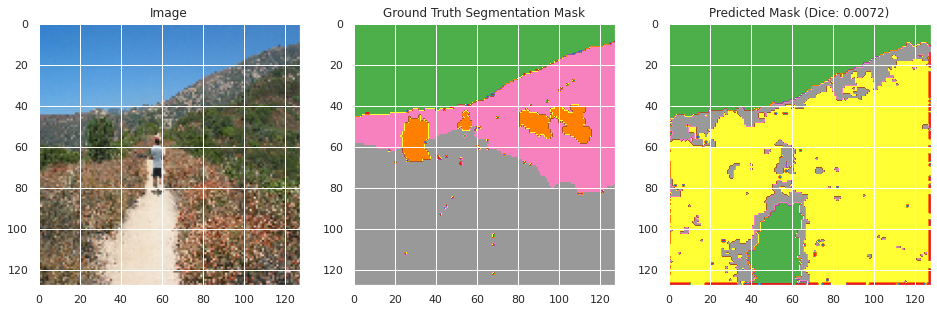

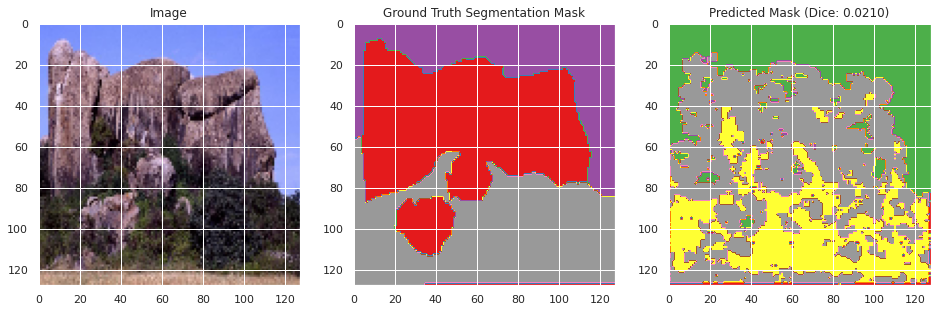

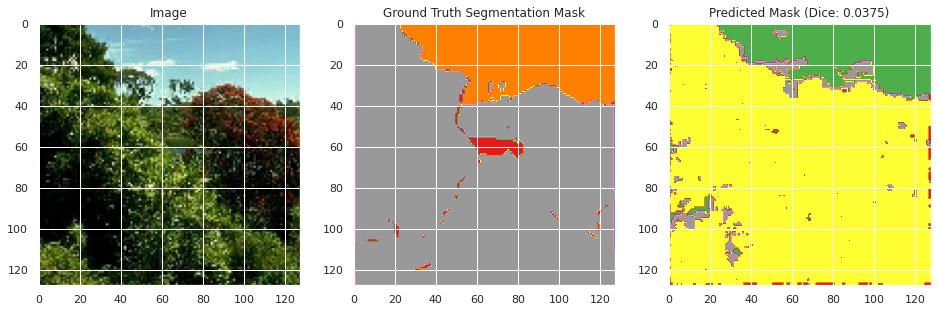

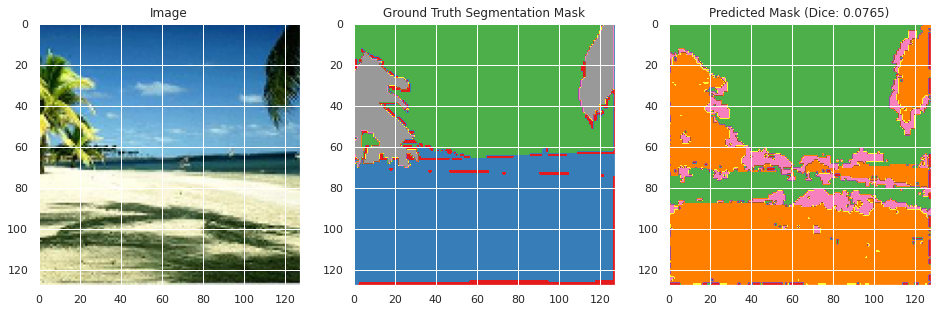

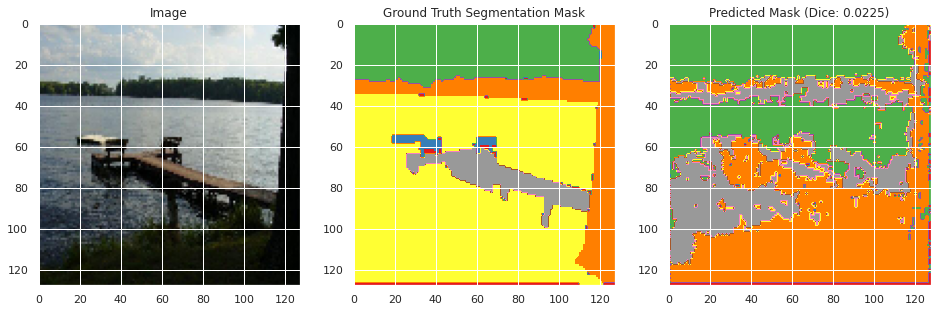

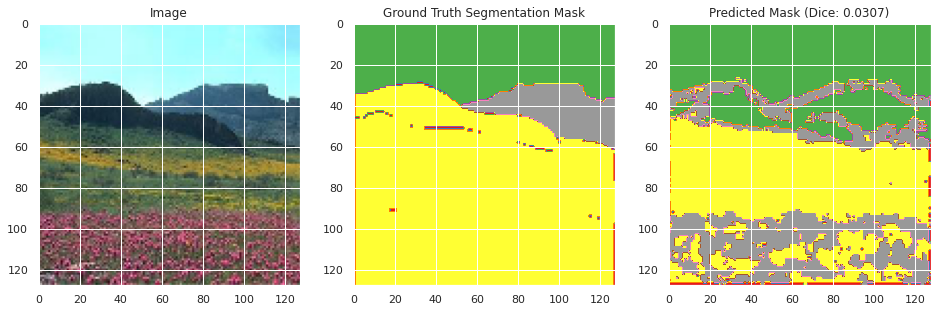

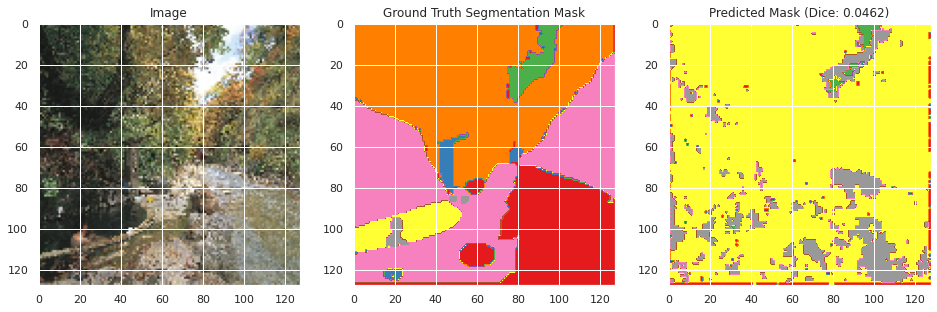

In [63]:
evaluate(model, testing_data[0], plot_frequency = 10)

Evaluation on training and validation data:

Mean Test Dice: 0.0434
Mean Test Accuracy: 0.3459


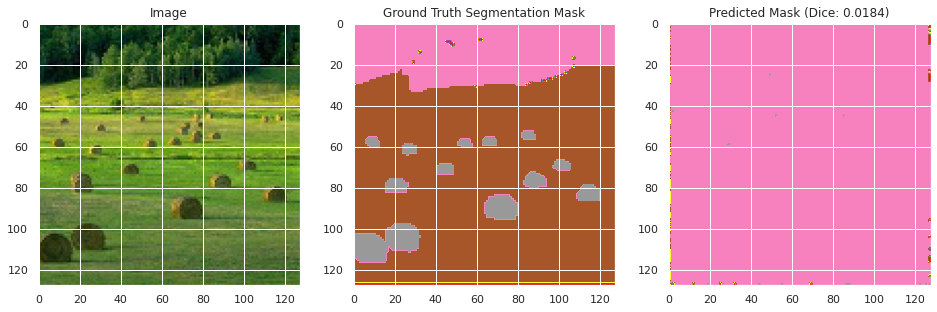

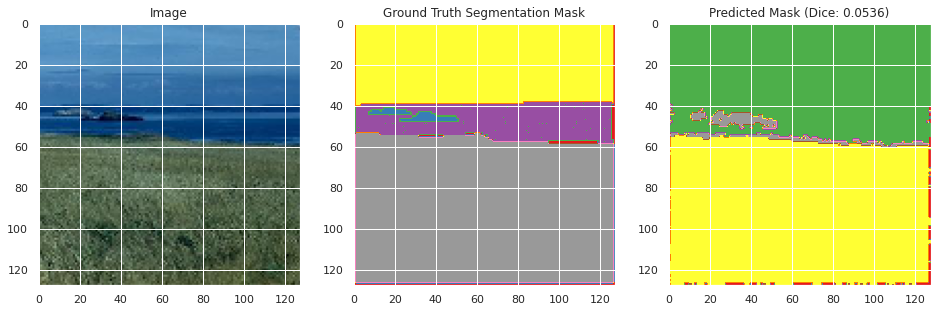

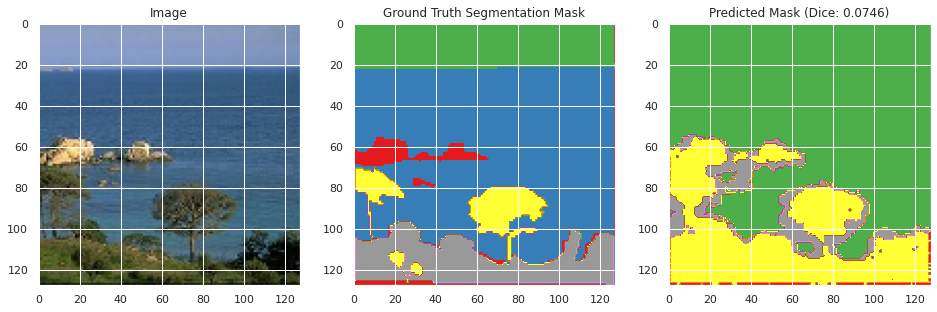

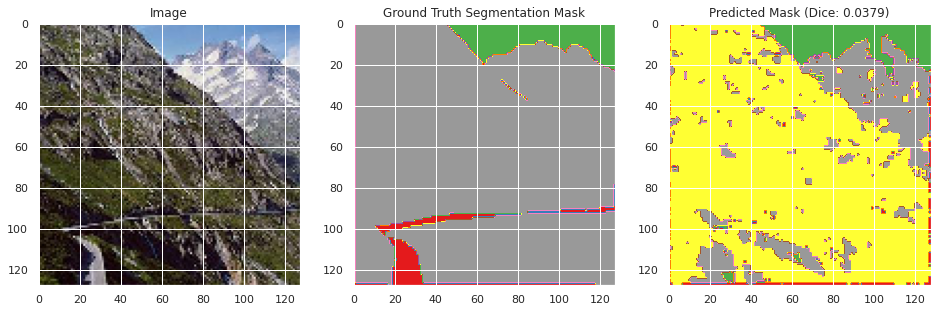

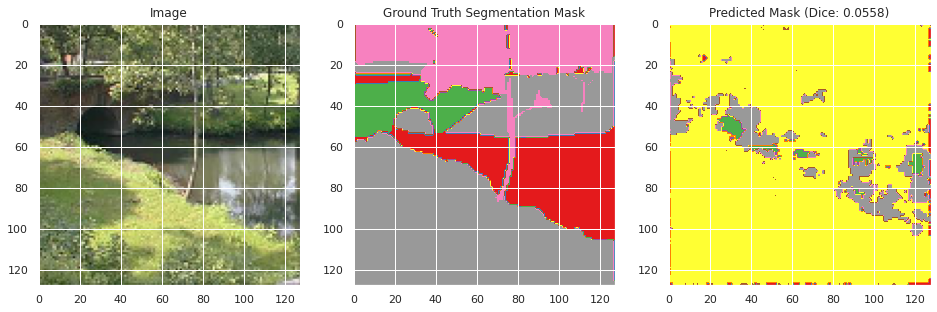

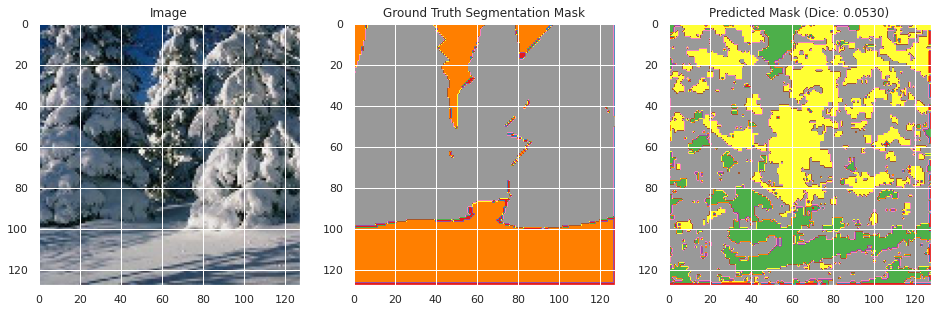

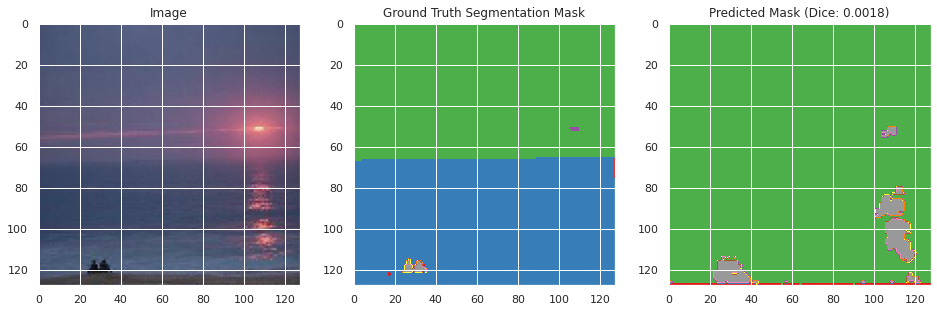

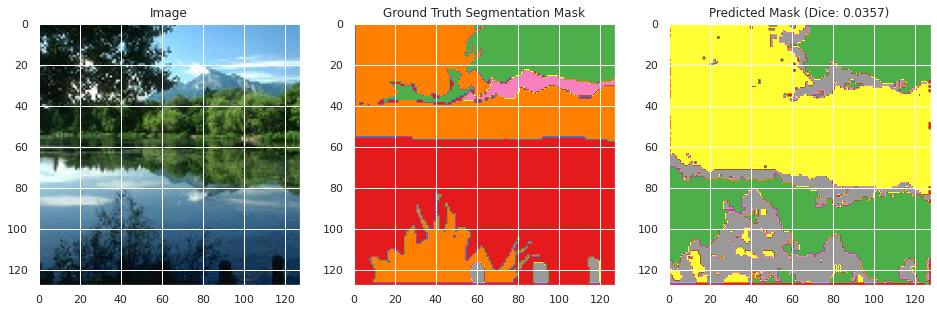

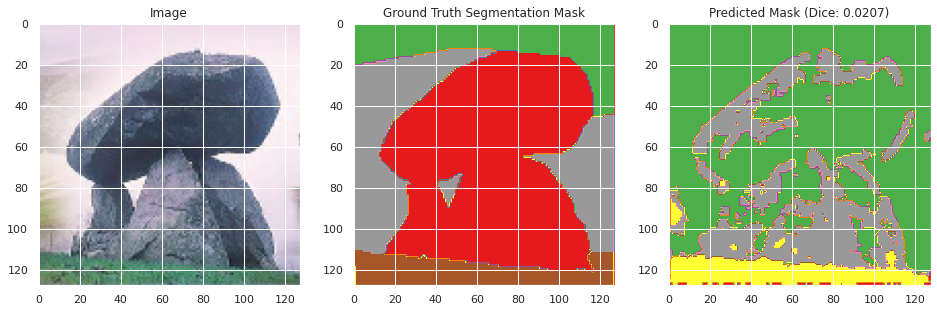

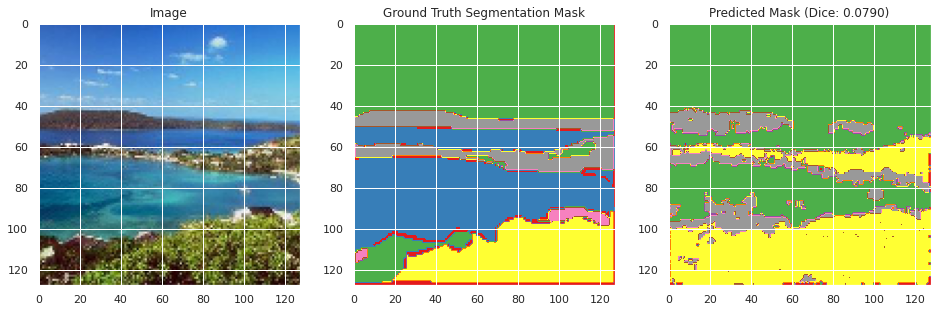

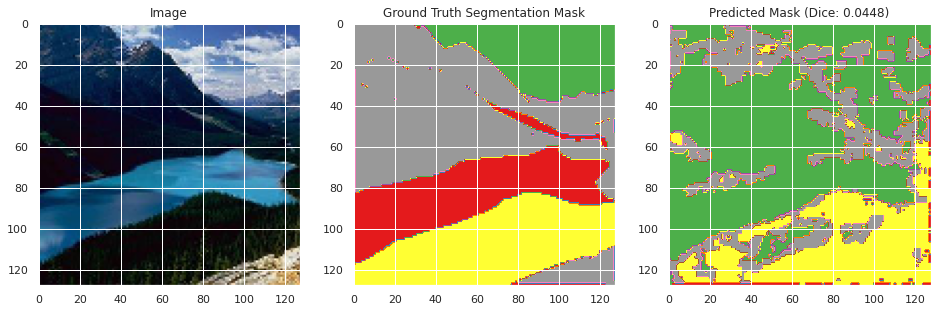

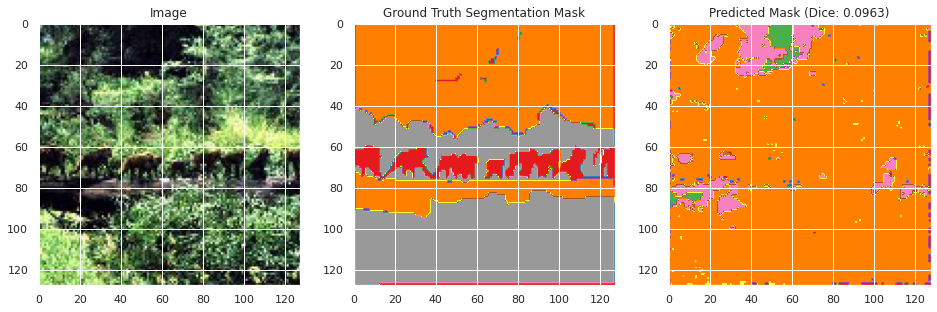

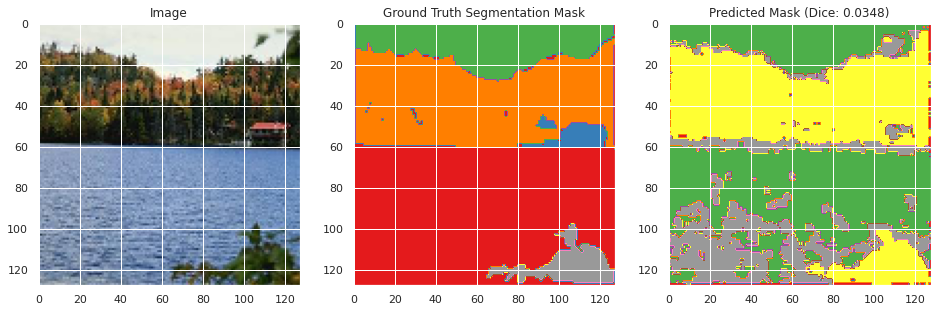

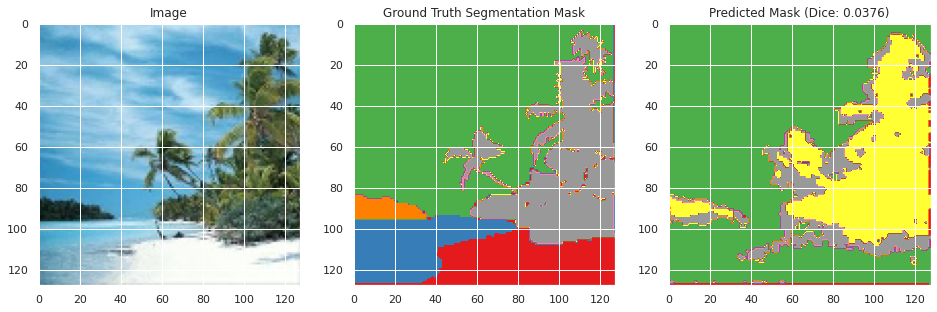

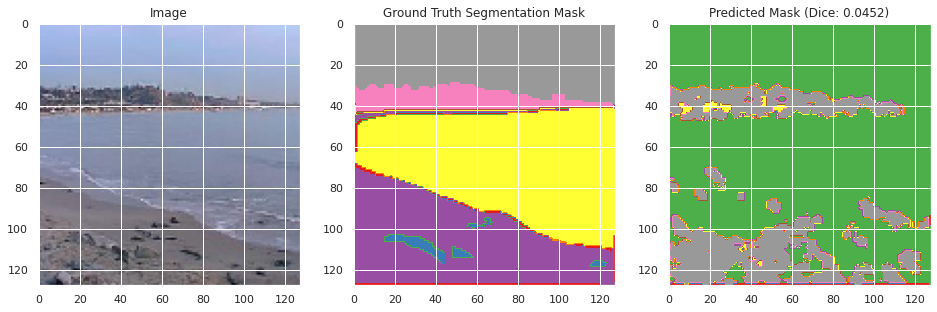

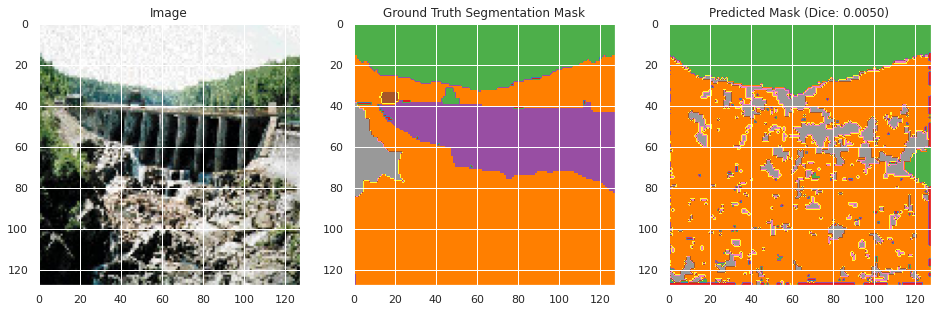

In [64]:
evaluate(model, validation_data[0])